In [1]:
import os
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn.preprocessing
import scipy.sparse
import scipy.io
import sklearn.mixture
from IPython.display import Audio, display
from anndata import AnnData
# import rpy2
# sc.settings.set_figure_params(dpi=100)
# sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# %load_ext rpy2.ipython
import leidenalg

In [2]:

################# MY ADDRESSES ###################################
WD = '/nfs/lab/jnewsome/pbmc_tenX_pipelineTemp/PBMC10'
SAMPLE_NAME = 'pbmc10'
REFERENCE_PROMOTER_NAMES = '/nfs/lab/jnewsome/references/gencode.v19.5kb_promoter_names.txt'
GENERAL_TITLE = 'PBMC10'
OUT_DIR = '/nfs/lab/jnewsome/pbmc_tenX_pipelineTemp'
QC_FILE = os.path.join(WD, '{}.qc_metrics.txt'.format(SAMPLE_NAME))
MATRIX_FILE = os.path.join(WD, '{}.mtx.gz'.format(SAMPLE_NAME))
REGIONS_FILE = os.path.join(WD, '{}.regions'.format(SAMPLE_NAME))
BARCODES_FILE = os.path.join(WD, '{}.barcodes'.format(SAMPLE_NAME))
sample_name = SAMPLE_NAME
wd = WD

##################################################################
# def allDone ():
#     display(Audio('/home/jnewsome/alerts/sweetalertsound5.wav', autoplay=True))
# def errorNoise ():
#         display(Audio('/home/jnewsome/alerts/alert_sonar.wav', autoplay=True))


This notebook take the out put from the analysis pipeline: /home/data/anaconda3/bin/python /nfs/lab/projects/pbmc_snATAC/scripts/snATAC_pipeline_10X.py -b cellranger_v1.1/outs/possorted_bam.bam -o lab_pipeline -n pbmc1 -t 24 -m 2 



# read depth distribution

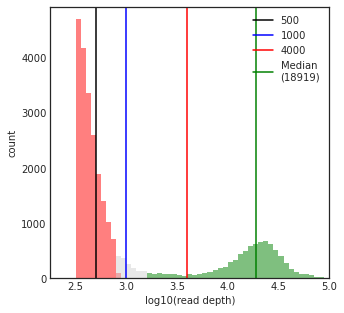

In [3]:
qc = pd.read_csv(os.path.join(wd, '{}.qc_metrics.txt'.format(sample_name)), sep='\t', header=0, index_col=0)
qc = qc.loc[qc['unique_usable_reads']>10**2.5]
qc['log10_unique_usable_reads'] = np.log10(qc['unique_usable_reads']+1)
qc = qc.sort_values('log10_unique_usable_reads')
gmm = sklearn.mixture.GaussianMixture(n_components=2, random_state=1).fit(qc[['log10_unique_usable_reads']])
pp = gmm.predict_proba(qc[['log10_unique_usable_reads']])
qc['low'] = [pp[i][0] for i in range(len(pp))]
qc['high'] = [pp[i][1] for i in range(len(pp))]

plt.style.use('seaborn-white')
fig, ax1 = plt.subplots(1,1,figsize=(5,5))
ax1.hist(qc.loc[qc['low']>=.99, 'log10_unique_usable_reads'], color='red', bins=np.arange(0,5,.05), alpha=.5, label='_nolegend_')
ax1.hist(qc.loc[qc['high']>=.99, 'log10_unique_usable_reads'], color='green', bins=np.arange(0,5,.05), alpha=.5, label='_nolegend_')
ax1.hist(qc.loc[(qc['high']<.99) & (qc['low']<.99), 'log10_unique_usable_reads'], color='lightgrey', bins=np.arange(0,5,.05), alpha=.5, label='_nolegend_')
ax1.axvline(np.log10(500), color='black', label='500')
ax1.axvline(np.log10(1000), color='blue', label='1000')
ax1.axvline(np.log10(4000), color='red', label='4000')
ax1.axvline(qc.loc[qc['high']>=.99, 'log10_unique_usable_reads'].median(), color='green', label='Median\n({})'.format(int(10**qc.loc[qc['high']>=.99, 'log10_unique_usable_reads'].median())))
ax1.set_xlim(2.25,5)
#ax1.set_ylim(0,1000)
ax1.set_ylabel('count')
ax1.set_xlabel('log10(read depth)')
ax1.legend()
plt.show()

After generating plot showing separation of low depth and high depth cells re-run pipeline with correct minimun read separation (in this case 4000 - the default was 1000, with worked better for combinatorial barcodes but with 10x is more deep data) /home/data/anaconda3/bin/python /nfs/lab/projects/pbmc_snATAC/scripts/snATAC_pipeline_10X.py -b cellranger_v1.1/outs/possorted_bam.bam -o lab_pipeline -n pbmc1 -t 24 -m 2 --skip-convert --minimum-reads 4000 --skip-rmdup --skip-qc

# clustering one sample

In [4]:

# read in sparse matrix and create anndata object
sp = scipy.io.mmread(os.path.join(wd, '{}.mtx.gz'.format(sample_name))).tocsr()
regions = open(os.path.join(wd, '{}.regions'.format(sample_name))).read().splitlines()
barcodes = open(os.path.join(wd, '{}.barcodes'.format(sample_name))).read().splitlines()
adata = AnnData(sp, {'obs_names':barcodes}, {'var_names':regions})

# read in qc metrics
metrics = pd.read_table(os.path.join(wd, '{}.qc_metrics.txt'.format(sample_name)), sep='\t', header=0, index_col=0)
adata.obs = adata.obs.join(metrics, how='inner')

promoters = pd.read_table(REFERENCE_PROMOTER_NAMES, sep='\t', header=None, index_col=0, names=['prom'])
promoter_names = promoters['prom'].to_dict()
adata2 = adata

In [5]:
adata = adata2 # resets adata to the original pulled from file

# filter out cells that are doublets or low quality - not used for initial run
#doublets = open(os.path.join(OUT_DIR, '{}.doublets1'.format(sample_name))).read().splitlines()
#doublets2 = open(os.path.join(OUT_DIR, '{}.doublets2'.format(sample_name))).read().splitlines()
#doublets3 = open(os.path.join(OUT_DIR, '{}.doublets3'.format(sample_name))).read().splitlines()
#doublets4 = open(os.path.join(OUT_DIR, '{}.doublets4'.format(sample_name))).read().splitlines()
#doublets5 = open(os.path.join(OUT_DIR, '{}.doublets5'.format(sample_name))).read().splitlines()
#doublets6 = open(os.path.join(OUT_DIR, '{}.doublets6'.format(sample_name))).read().splitlines()
#low_frip = open(os.path.join(OUT_DIR, '{}.lowfrip'.format(sample_name))).read().splitlines()

#adata = adata[(~adata.obs.index.isin(low_frip)),:].copy()
#adata = adata[(~adata.obs.index.isin(low_frip)) & (~adata.obs.index.isin(doublets))& (~adata.obs.index.isin(doublets2))& (~adata.obs.index.isin(doublets3))& (~adata.obs.index.isin(doublets4)),:].copy()
#adata = adata[(~adata.obs.index.isin(low_frip)) & (~adata.obs.index.isin(doublets)),:].copy()
#adata = adata[(~adata.obs.index.isin(low_frip)) & (~adata.obs.index.isin(doublets))& (~adata.obs.index.isin(doublets2)) & (~adata.obs.index.isin(doublets3)) & (~adata.obs.index.isin(doublets4)) & (~adata.obs.index.isin(doublets5)) ,:].copy()

adata.var.index = [promoter_names[b] if b in promoter_names else b for b in adata.var.index]
adata.var_names_make_unique(join='.')

adata.raw = sc.pp.log1p(adata, copy=True)
adata_orig = adata.copy()

# normalize cells to uniform read depth and search for highly variable windows
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
adata_filter = sc.pp.filter_genes_dispersion(adata.X, flavor='seurat', n_bins=50)
hvgs = adata.var.loc[adata_filter.gene_subset].index.tolist()
len(hvgs)

14062

In [6]:
# filter for highly variable windows
adata = adata[:,adata.var.index.isin(hvgs)]
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# regress out read depth 
adata.obs['log10_usable_counts'] = np.log10(adata_orig[:, adata_orig.var.index.isin(hvgs)].X.sum(axis=1).A1)
adata_orig = None
sc.pp.log1p(adata)
sc.pp.regress_out(adata, ['log10_usable_counts'])
sc.pp.scale(adata)



Trying to set attribute `.obs` of view, copying.


In [7]:
# pca, calculating neighbors, clustering, and UMAP
sc.tl.pca(adata, zero_center=False, random_state=0)
sc.pp.neighbors(adata, n_neighbors=30, method='umap', metric='cosine', random_state=0, n_pcs=50)
sc.tl.leiden(adata, resolution=1.5, random_state=0)
sc.tl.umap(adata, min_dist=0.3, random_state=0)



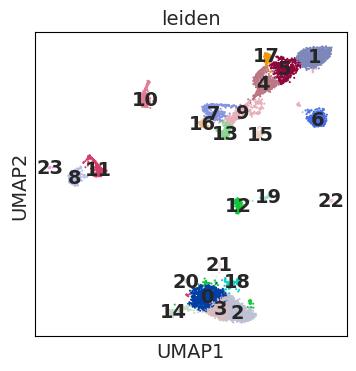

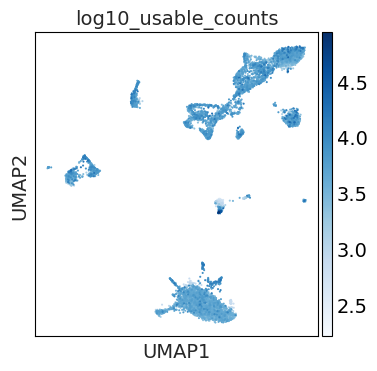

In [8]:
# plot clusters (leiden) and read depth on UMAP coordinates
sc.settings.set_figure_params(dpi=100)
sc.pl.umap(adata, color=['leiden'], size=9, legend_loc='on data')
sc.pl.umap(adata, color=['log10_usable_counts'], size=9, color_map='Blues')



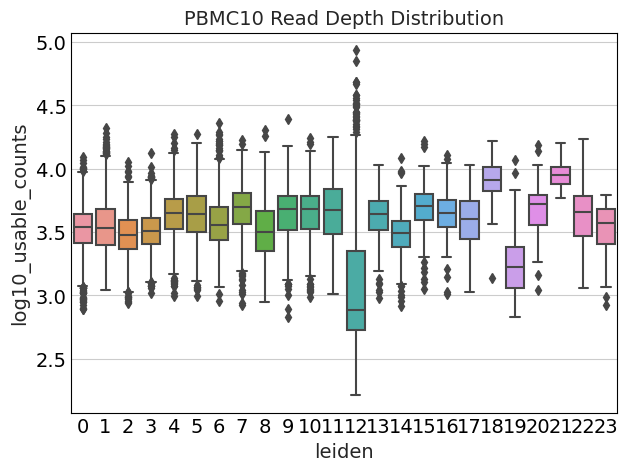

In [9]:
# boxplot of read depth distribution (reads within highly variable windows)
readDepthTitle = GENERAL_TITLE + " Read Depth Distribution"
fig, ax1 = plt.subplots(1,1,figsize=(7,5))
sns.boxplot(x='leiden', y='log10_usable_counts', data=adata.obs).set_title(readDepthTitle)
plt.show()


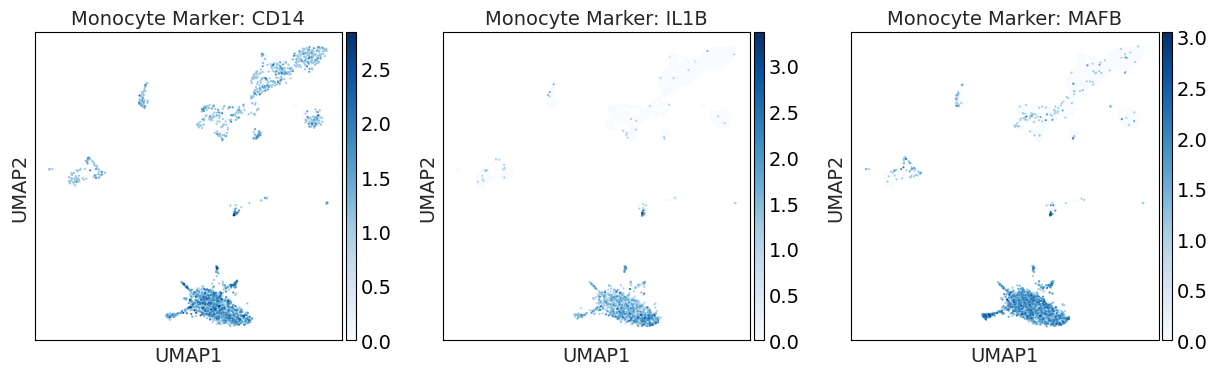

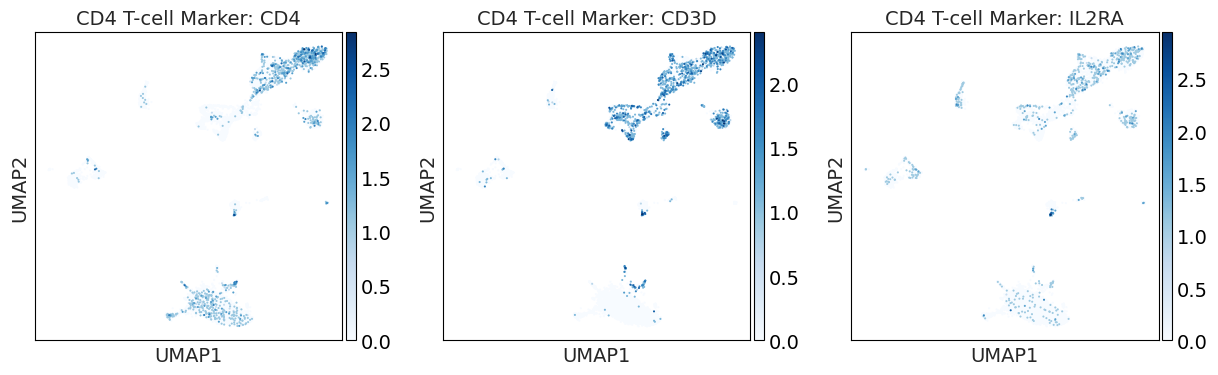

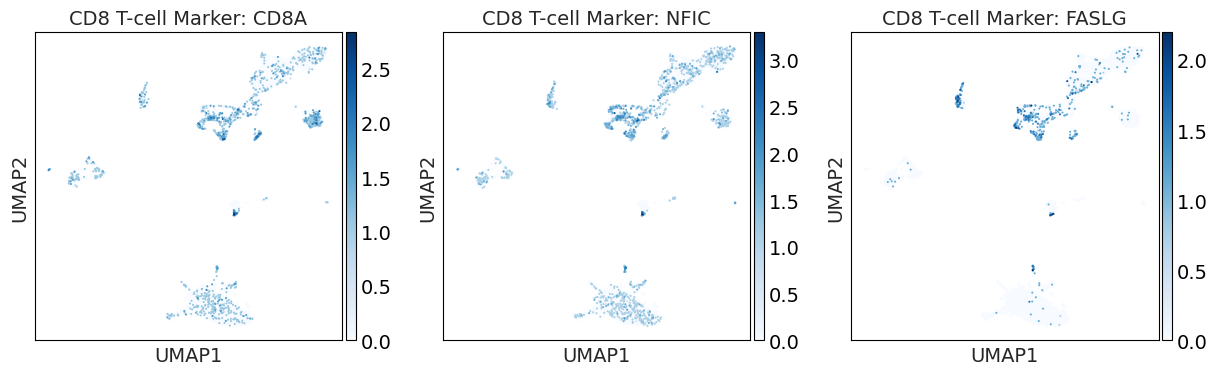

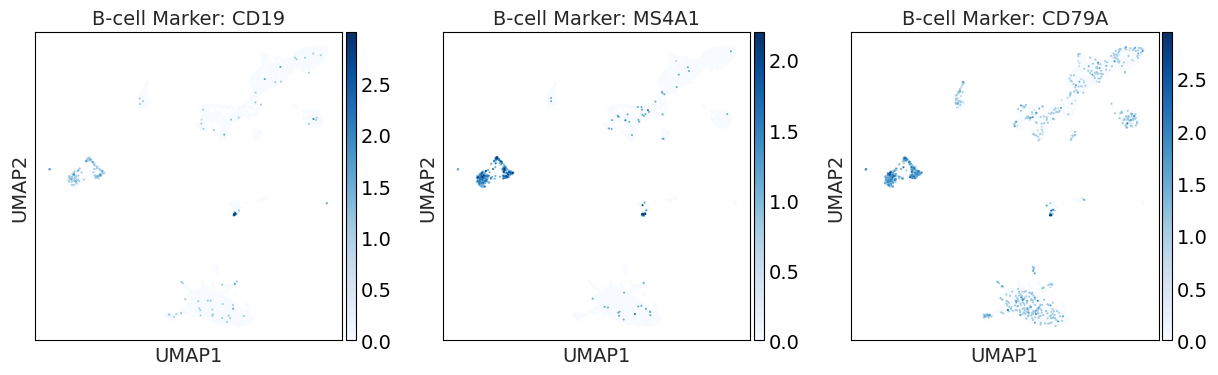

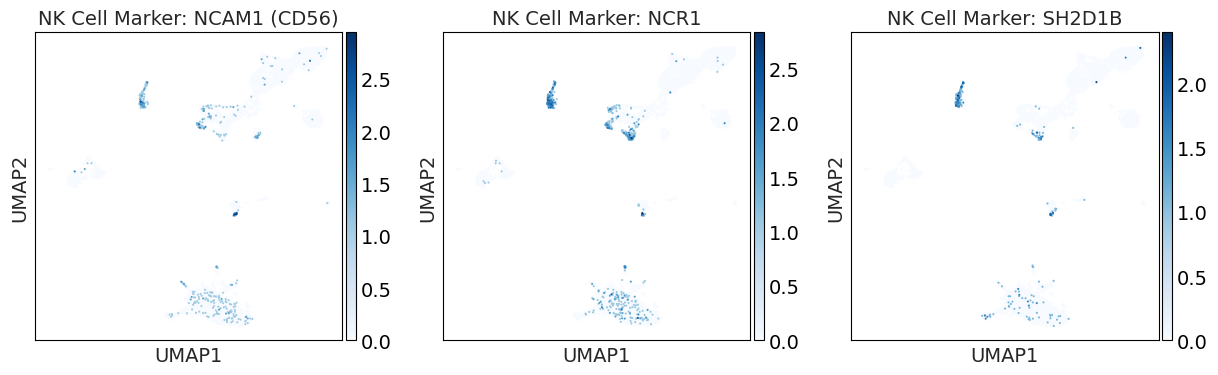

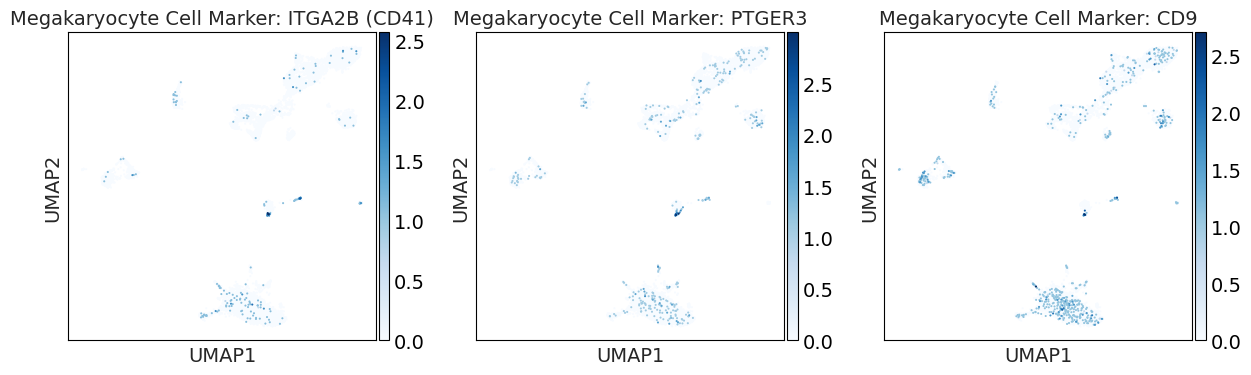

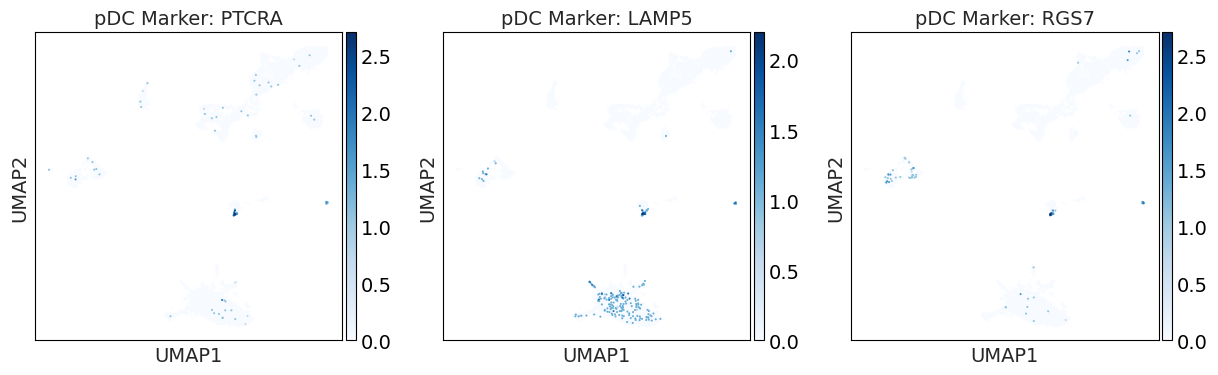

In [10]:

# plot marker promoter on UMAP coordinates
sc.pl.umap(adata, color=['CD14','IL1B','MAFB'], size=9, color_map='Blues', frameon=True, use_raw=True, title=['Monocyte Marker: CD14','Monocyte Marker: IL1B','Monocyte Marker: MAFB']) # Monocyte
sc.pl.umap(adata, color=['CD4','CD3D','IL2RA'], size=9, color_map='Blues', frameon=True, use_raw=True, title=['CD4 T-cell Marker: CD4','CD4 T-cell Marker: CD3D','CD4 T-cell Marker: IL2RA']) # CD4 T-cell
sc.pl.umap(adata, color=['CD8A','NFIC','FASLG'], size=9, color_map='Blues', frameon=True, use_raw=True, title=['CD8 T-cell Marker: CD8A','CD8 T-cell Marker: NFIC','CD8 T-cell Marker: FASLG']) # CD8 T-cell
sc.pl.umap(adata, color=['CD19','MS4A1','CD79A'], size=9, color_map='Blues', frameon=True, use_raw=True, title=['B-cell Marker: CD19','B-cell Marker: MS4A1','B-cell Marker: CD79A']) #B-cell 
sc.pl.umap(adata, color=['NCAM1','NCR1','SH2D1B'], size=9, color_map='Blues', frameon=True, use_raw=True, title=['NK Cell Marker: NCAM1 (CD56)','NK Cell Marker: NCR1','NK Cell Marker: SH2D1B']) # NK cell
sc.pl.umap(adata, color=['ITGA2B','PTGER3','CD9'], size=9, color_map='Blues', frameon=True, use_raw=True, title=['Megakaryocyte Cell Marker: ITGA2B (CD41)','Megakaryocyte Cell Marker: PTGER3','Megakaryocyte Cell Marker: CD9']) # Megakaryocyte
sc.pl.umap(adata, color=['PTCRA','LAMP5','RGS7'], size=9, color_map='Blues', frameon=True, use_raw=True, title=['pDC Marker: PTCRA','pDC Marker: LAMP5','pDC Marker: RGS7']) #pDCs


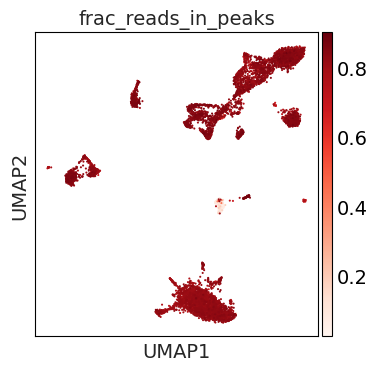

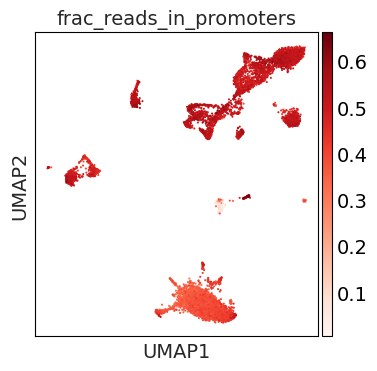

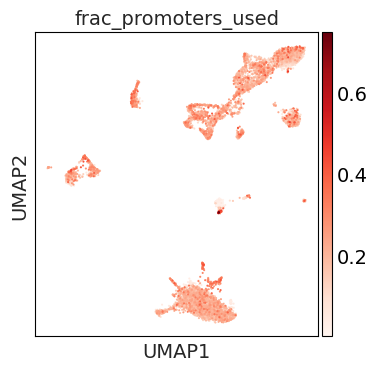

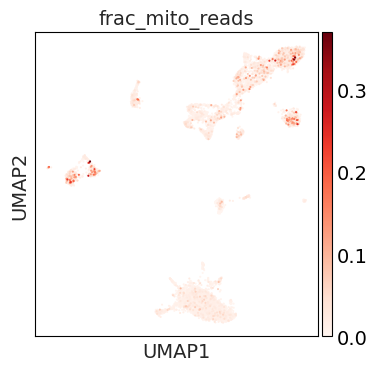

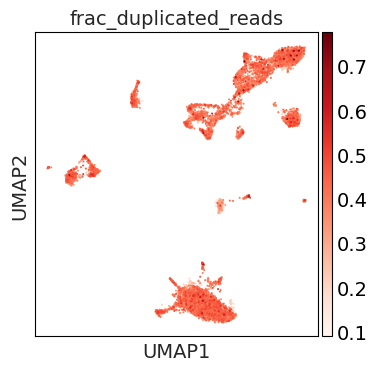

<class 'anndata._core.anndata.AnnData'>


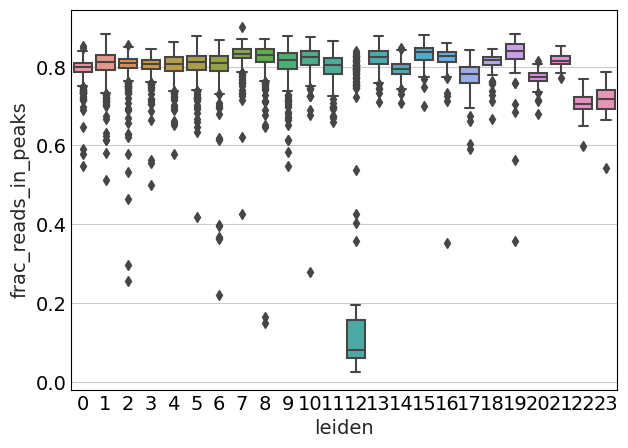

In [11]:
# plot other QC metrics
sc.pl.umap(adata, color=['frac_reads_in_peaks'], cmap='Reds', size=9, legend_loc='on data')
sc.pl.umap(adata, color=['frac_reads_in_promoters'], cmap='Reds', size=9, legend_loc='on data')
sc.pl.umap(adata, color=['frac_promoters_used'], cmap='Reds', size=9, legend_loc='on data')
sc.pl.umap(adata, color=['frac_mito_reads'], cmap='Reds', size=9, legend_loc='on data')
sc.pl.umap(adata, color=['frac_duplicated_reads'], cmap='Reds', size=9, legend_loc='on data')


print(type(adata))


#sc.pl.umap(adata, color=, cmap='Reds', size=9, legend_loc='on data', title=['Cells with HIV Mapped Reads'])



fig, ax1 = plt.subplots(1,1,figsize=(7,5))
sns.boxplot(x='leiden', y='frac_reads_in_peaks', data=adata.obs)
plt.show()

In [ ]:
       
#get a list of cells in low quality clusters
#adata.obs.loc[(adata.obs['leiden'].isin(['7']))].to_csv(os.path.join(OUT_DIR, '{}.lowfrip'.format(sample_name)), header=None, columns=[])
#adata.obs.head()

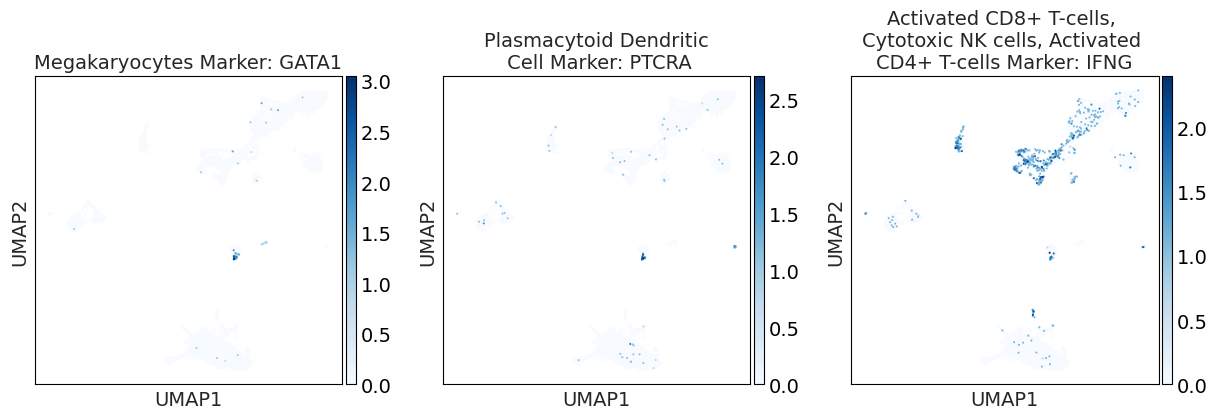

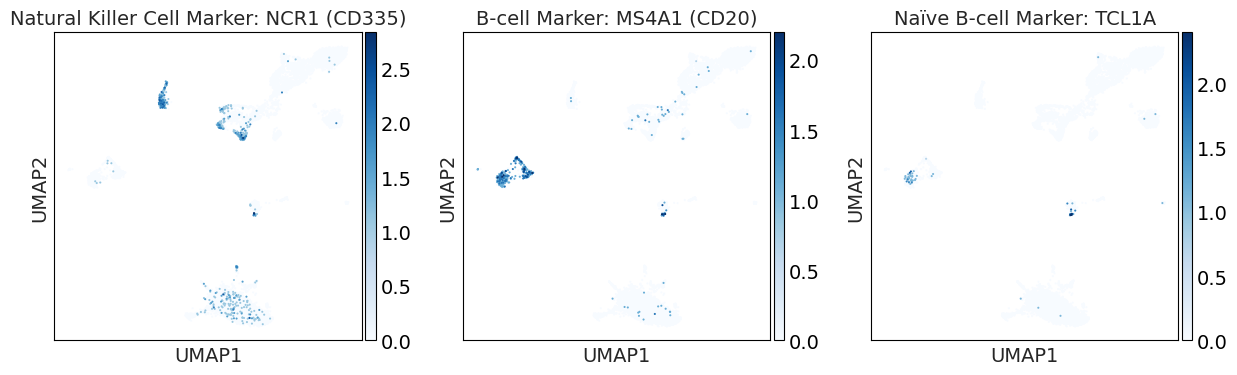

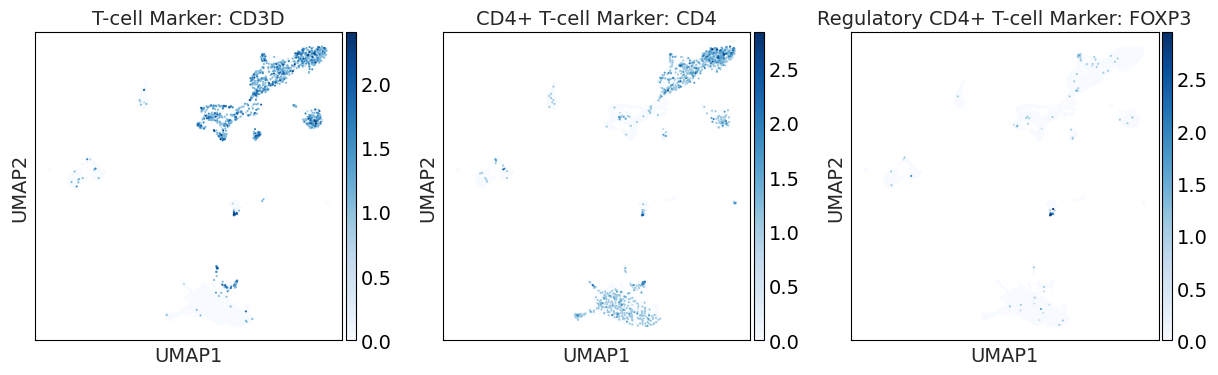

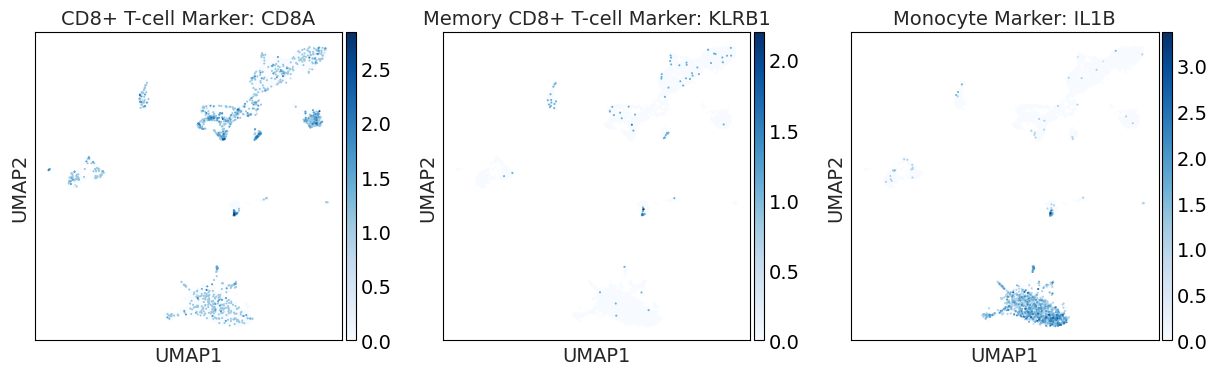

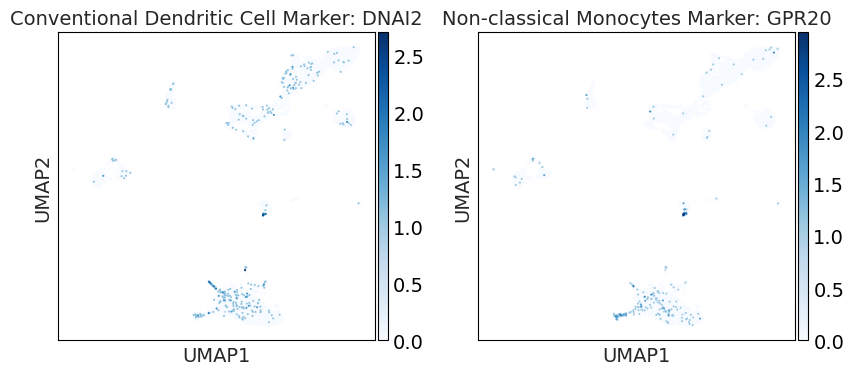

In [12]:
# plot marker promoter on UMAP coordinates
sc.pl.umap(adata, color=['GATA1','PTCRA','IFNG'], size=9, color_map='Blues', frameon=True, use_raw=True, title=['Megakaryocytes Marker: GATA1','Plasmacytoid Dendritic\n Cell Marker: PTCRA','Activated CD8+ T-cells, \nCytotoxic NK cells, Activated \nCD4+ T-cells Marker: IFNG']) 
sc.pl.umap(adata, color=['NCR1','MS4A1','TCL1A'], size=9, color_map='Blues', frameon=True, use_raw=True, title=['Natural Killer Cell Marker: NCR1 (CD335)','B-cell Marker: MS4A1 (CD20)','Naïve B-cell Marker: TCL1A']) # 
sc.pl.umap(adata, color=['CD3D','CD4','FOXP3'], size=9, color_map='Blues', frameon=True, use_raw=True, title=['T-cell Marker: CD3D','CD4+ T-cell Marker: CD4','Regulatory CD4+ T-cell Marker: FOXP3']) # 
sc.pl.umap(adata, color=['CD8A','KLRB1','IL1B'], size=9, color_map='Blues', frameon=True, use_raw=True, title=['CD8+ T-cell Marker: CD8A','Memory CD8+ T-cell Marker: KLRB1','Monocyte Marker: IL1B']) # 
sc.pl.umap(adata, color=['DNAI2','GPR20'], size=9, color_map='Blues', frameon=True, use_raw=True, title=['Conventional Dendritic Cell Marker: DNAI2','Non-classical Monocytes Marker: GPR20']) # 

In [13]:
outfilename = '/nfs/lab/jnewsome/pbmc_clusters/pbmc10.initialClustering.noQC.h5ad'

adata.write_h5ad(outfilename)

In [3]:
LOW_FRIP_REMOVAL_ROUND = '1'

outfilename = '/nfs/lab/jnewsome/pbmc_clusters/'+ SAMPLE_NAME + '.initialClustering.noQC.h5ad'
adata = sc.read_h5ad(outfilename)
totalCellCount = len(adata.obs)
print('total # cells = ', totalCellCount)
clusterList = ['12']
clusterALen =  len(adata.obs[adata.obs['leiden'].isin(clusterList)])
print('# number of cells in cluster 12 = ', clusterALen)

clusterList = ['19']
clusterBLen = len(adata.obs[adata.obs['leiden'].isin(clusterList)])
print('# number of cells in cluster 19 = ', clusterBLen)
leftover = totalCellCount - clusterALen - clusterBLen
print('# cells remaining = ', leftover)

badClusterList = ['12','19']
badBarcodes = adata.obs[adata.obs['leiden'].isin(badClusterList)].index

badBarcodeFileName = '/nfs/lab/jnewsome/pbmc_clusters/'+ SAMPLE_NAME + '.lowFrip.round'+ LOW_FRIP_REMOVAL_ROUND + '.justBarcodes.txt'
badBarMoreFileName = '/nfs/lab/jnewsome/pbmc_clusters/'+ SAMPLE_NAME + '.lowFrip.round'+ LOW_FRIP_REMOVAL_ROUND + '.txt'
with open(badBarcodeFileName, 'w') as filehandle:
    filehandle.writelines("%s\n" % bar for bar in badBarcodes)
sub  = adata.obs.loc[adata.obs['leiden'].isin(badClusterList)]
sub.to_csv(badBarMoreFileName, header=True, sep = '\t')


total # cells =  7464
# number of cells in cluster 12 =  244
# number of cells in cluster 19 =  72
# cells remaining =  7148


After findinf low quality cells, go back and uncomment the relative part (low_frif and adata) in the clustering part and re-run

# subclustering to remove doublets

In [ ]:
clusterChosen = '11'
subset_cluster = [clusterChosen]
sc.tl.louvain(adata, restrict_to=('leiden',subset_cluster), resolution=2, random_state=0, key_added='subset')
sc.pl.umap(adata, color=['subset'], size=9)#, legend_loc='on data')

adata_obs = adata.obs.copy()
adata_obs['cells'] = 1
subset_genes = ['CD14','MAFB','IL1B',
                'CD19','MS4A1','CD79A',
                'CD4','IL2RA','CD3D',
                'CD8A','NFIC','FASLG',
                'NCAM1','NCR1','SH2D1B',
                'ITGA2B','PTGER3','CD9',
                'PTCRA','LAMP5','RGS7']
for gene in subset_genes:
    adata_obs[gene] = (adata.raw.X[:,adata.raw.var.index.get_loc(gene)].todense().A1 > 0).astype(int)
subset_obs = adata_obs.loc[adata_obs['subset'].str.contains(',')]
subset_pct = pd.DataFrame(index=sorted(set(subset_obs['subset'])))
for gene in subset_genes:
    subset_pct[gene] = (subset_obs.groupby('subset')[gene].sum()/subset_obs.groupby('subset')['cells'].count()).dropna()
fig, ax1 = plt.subplots(1,1,figsize=(9,7))
sns.heatmap(subset_pct, cmap='Reds', yticklabels=1, ax=ax1, vmax=.25)
plt.show()

fig, ax1 = plt.subplots(1,1,figsize=(5,5))
subset = adata.obs.join(pd.DataFrame(adata.obsm['X_umap'], index=adata.obs.index, columns=['UMAP1','UMAP2']), how='inner', rsuffix='_right')
subset = subset.loc[subset['leiden'].isin(subset_cluster)]
for s in sorted(set(subset['subset'])):
    ax1.scatter(subset.loc[subset['subset']==s, 'UMAP1'], subset.loc[subset['subset']==s, 'UMAP2'], alpha=1, s=4, label=s)
ax1.legend(markerscale=3)
plt.show()


fig, ax1 = plt.subplots(1,1,figsize=(12,5))
sns.boxplot(x='subset', y='log10_usable_counts', data=adata.obs, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
plt.show()

fig, ax1 = plt.subplots(1,1,figsize=(12,5))
sns.boxplot(x='subset', y='frac_reads_in_peaks', data=adata.obs, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
plt.show()

fig, ax1 = plt.subplots(1,1,figsize=(12,5))
sns.boxplot(x='subset', y='frac_promoters_used', data=adata.obs, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
plt.show()



In [ ]:
subClustersToRemove = ['11,0']

sub  = adata.obs.loc[adata.obs['subset'].isin(subClustersToRemove)]

sub.to_csv(os.path.join(OUT_DIR, '{}.doublets6_cluster{}'.format(sample_name, clusterChosen)), header=False, columns=[])
sub.head()

After listing all the doublets and writing, repeat the clustering

second round of subclustering:

In [14]:
#secondRoundSubClustersToRemove = [ '3,16', '4,0', '5,2', '5,12', '5,15', '6,8', '7,6', '7,7', '8,1', '8,11', '9,5', '10,0', '10,1', '10,2', '11,0', '11,3', '11,21', '12,2', '12,5']
#sub  = adata.obs.loc[adata.obs['subset'].isin(secondRoundSubClustersToRemove)]

#leidenList = ['3', '4','5', '6', '7', '8', '9', '10', '11', '12']


#sub  = adata.obs.loc[adata.obs['3'].isin(secondRoundSubClustersToRemove)]
#sub1  = adata.obs.loc[adata.obs['4'].isin(secondRoundSubClustersToRemove)]
#sub2  = adata.obs.loc[adata.obs['5'].isin(secondRoundSubClustersToRemove)]
#sub3  = adata.obs.loc[adata.obs['6'].isin(secondRoundSubClustersToRemove)]
#sub4  = adata.obs.loc[adata.obs['7'].isin(secondRoundSubClustersToRemove)]

sub11 = open(os.path.join(OUT_DIR, '{}.doublets6_cluster11'.format(sample_name))).read().splitlines()





#print(sub3)



finalDoubletListRound2 = list();

finalDoubletListRound2.extend(sub11)



#frames = [sub3, sub4, sub5, sub7, sub8, sub9, sub12]
#alldoublets = pd.concat(frames)
#print(finalDoubletListRound2)
#finalDoubletListRound2.to_csv(os.path.join(OUT_DIR, '{}.doublets2'.format(sample_name, clusterChosen)), header=False, columns=[])

outDoubletName = OUT_DIR + "/" + sample_name + ".doublets6"

print(outDoubletName)
outDoubletFile = open(outDoubletName, 'w')


for i in finalDoubletListRound2:
    outDoubletFile.write(i + "\n")

outDoubletFile.close()
#print(type(sub))
#for i in leidenList:
    


#print(finalDoubletListRound2)



/nfs/lab/projects/pbmc_hiv_snATAC/sc/clusterOutput/ID237.doublets6


In [60]:
sub.to_csv(os.path.join(OUT_DIR, '{}.doublets2'.format(sample_name)), header=False, columns=[])

### Assign cluster labels

In [25]:
cluster_labels = {
                  '0' : 'CD8_T-cell',
                  '1' : 'CD4_T-cell',
                  '2' : 'CD4_T-cell',
                  '3' : 'Monocyte',
                  '4' : 'CD8_T-cell',
                  '5' : 'CD4_T-cell',
                  '6' : 'CD8_T-cell',
                  '7' : 'CD8_T-cell',
                  '8' : 'B-cell',
                  '9' : 'NK-cell',
                  '10' : 'CD4_T-cell',
                  '11' : 'Monocyte',
                  '12' : 'B-cell',
                  '13' : 'CD4_T-cell',
                  '14' : 'CD4_T-cell',
                  '15' : 'CD8_T-cell',
                  '16' : 'CD8_T-cell'
    
                  '0' : '',
                  '1' : '',
                  '2' : '',
                  '3' : '',
                  '4' : '',
                  '5' : '',
                  '6' : '',
                  '7' : '',
                  '8' : '',
                  '9' : '',
                  '10' : '',
                  '11' : '',
                  '12' : '',
                  '13' : 'CD4_T-cell',
                  '14' : 'CD4_T-cell',
                  '15' : 'CD8_T-cell',
                  '16' : 'CD8_T-cell'
    
    
    
                 }
### not sure cd4 and cd8 clusters

In [26]:
clusters = pd.DataFrame(adata.obsm['X_umap'], columns=['UMAP1','UMAP2'], index=adata.obs.index)
clusters['leiden'] = clusters.index.map(adata.obs['leiden'])
clusters['cluster'] = clusters['leiden'].map(cluster_labels)
clusters.to_csv(os.path.join(OUT_DIR, '{}.cluster_labels_after4Rounds.txt'.format(SAMPLE_NAME))), sep='\t')